# Using BERT to classify medicine reviews
In this dataset (UCI Medicine Reviews), our task was to predict the condition the reviewer was suffering from based on their review. In this notebook, I finetune BERT with a sequence classification head to predict the condition using the reviews.

In [1]:
#import required libraries
#a script from https://github.com/Bjarten/early-stopping-pytorch#:~:text=Early%20stopping%20is%20a%20form,a%20row%20the%20training%20stops.
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.model_selection import train_test_split
from early_stopping_script import EarlyStopping
from torch.utils.data import DataLoader
import itertools

In [2]:
#import data into dataframes
train = pd.read_csv('/kaggle/input/drug-reviews/drugLibTrain_raw.tsv', sep='\t')
test = pd.read_csv('/kaggle/input/drug-reviews/drugLibTest_raw.tsv', sep='\t')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3107 non-null   object
 7   sideEffectsReview  3105 non-null   object
 8   commentsReview     3099 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


There are some missing values, so we will drop those rows.

In [4]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [5]:
#we will be doing EDA on the entire dataset
train = pd.concat([train, test])

# Data Preparation
We will only be using the benefits, side effects and overall comments reviews as our predictors.

In [6]:
#combine the reviews into one column
train['combinedReview'] = train['benefitsReview'] + '.' + \
        train['sideEffectsReview'] + '.' + train['commentsReview']

In [7]:
#check number of classes
train['condition'].nunique()

1804

<AxesSubplot:>

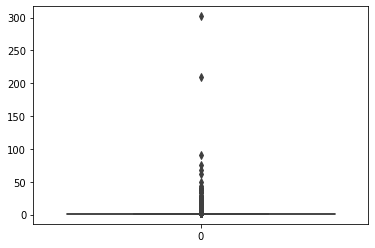

In [8]:
#check distribution of classes
sns.boxplot(data = train['condition'].value_counts())

There are many conditions, most of which have very few observations (the median is less than 10). Hence there is insufficient data for them and we will only predict for the top 10 classes.

In [9]:
#only get rows for top 10 conditions by observation count
top_10_conditions = train['condition'].value_counts(ascending=False).index[:10]
top_10 = train[train['condition'].isin(top_10_conditions)]

<AxesSubplot:>

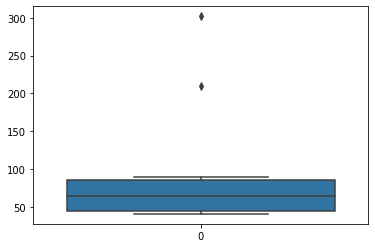

In [10]:
#check distribution of classes for top 10 conditions
sns.boxplot(data = top_10['condition'].value_counts())

In [11]:
top_10['condition'].value_counts()

depression             302
acne                   210
anxiety                 90
insomnia                75
birth control           68
high blood pressure     62
allergies               49
migraine                44
add                     41
asthma                  41
Name: condition, dtype: int64

<AxesSubplot:>

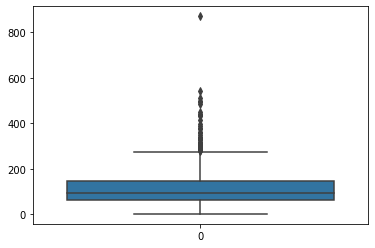

In [12]:
#check lengths of reviews (number of tokens)
lengths_combinedReview = top_10['combinedReview'].str.split().str.len()
sns.boxplot(data = lengths_combinedReview.reset_index(drop=True))

There are outliers with more than 300 words. For BERT, to balance speed of training and accuracy, the limit of number of tokens will be adjusted to 250.

In [13]:
#extract only the columns needed
top_10_shorter = top_10[['condition', 'combinedReview']].copy()
top_10_shorter.head()

,condition,combinedReview
6,add,"My mood has noticably improved, I have more en..."
7,depression,Although this drug was originally prescribed f...
9,allergies,none - did nothing to help allergies. i just h...
11,add,Smoother more gradual onset and effect than Ad...
12,depression,I found that this drug helps significantly wit...


In [14]:
#remove links from reviews
def clean_text(x):
    y = re.sub(r'(?:http:\/\/)?www\.[^\s\,]+', '', x, flags=re.IGNORECASE)
    return y

top_10_shorter['combinedReview'] = top_10_shorter['combinedReview'].apply(lambda x: clean_text(x))

In [15]:
#generate class labels for input into BERT
top_10_shorter['condition_code'] = top_10_shorter.groupby('condition').ngroup()
classes = top_10_shorter[['condition', 'condition_code']].drop_duplicates().sort_values('condition_code')['condition']
classes

22                    acne
6                      add
9                allergies
15                 anxiety
117                 asthma
50           birth control
7               depression
107    high blood pressure
33                insomnia
211               migraine
Name: condition, dtype: object

In [16]:
#stratified sampling - train test split
X_train, X_test, y_train, y_test = train_test_split(top_10_shorter['combinedReview'], top_10_shorter['condition_code'], 
                                                    test_size=0.2, random_state=42, shuffle=True, stratify=top_10_shorter['condition_code'])
#train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.15, random_state=42, shuffle=True, stratify=y_train)

In [17]:
print(f'No. train observations: {len(X_train)}')
print(f'No. validation observations: {len(X_val)}')
print(f'No. test observations: {len(X_test)}')

No. train observations: 667
No. validation observations: 118
No. test observations: 197


Text(0.5, 1.0, 'Test')

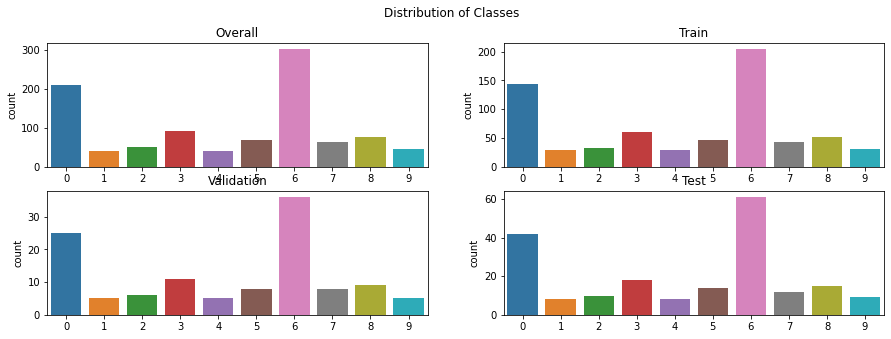

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Distribution of Classes')

# Overall
sns.countplot(ax=axes[0, 0], data=top_10_shorter['condition_code'], \
              x=top_10_shorter['condition_code'].values)
axes[0, 0].set_title('Overall')

# Train
sns.countplot(ax=axes[0, 1], data=y_train, x=y_train.values)
axes[0, 1].set_title('Train')

# Validation
sns.countplot(ax=axes[1, 0], data=y_val, x=y_val.values)
axes[1, 0].set_title('Validation')

# Test
sns.countplot(ax=axes[1, 1], data=y_test, x=y_test.values)
axes[1, 1].set_title('Test')

The proportions of each class is the same in all the datasets.

In [19]:
#customised dataset to accept dataframe input
#dataset classes are used to wrap the data rows for access by other classes like dataloader
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        #returns (label, x) to collate function
        row = self.dataframe.iloc[index]
        return (
            row['condition_code'],
            row['combinedReview']
        )

In [20]:
#format train val test series back into df to load into dataset
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

In [21]:
#create datasets
trainset = ReviewsDataset(train_df)
testset = ReviewsDataset(test_df)
valset = ReviewsDataset(val_df)

In [22]:
#load BERT tokenizer from torch hub
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [23]:
#detect if using CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
#define collation function - how to return a batch of data
#return 3 tensors required by BERT: labels, token ids, attention masks
#labels - class the observation belongs to
#token ids - the numerical id of the token e.g. [PAD] has an ID of 0
#attention mask - indicates the position of paddings [PAD] is 0, anything else is 1
#label size (batch size,)
#token id size (batch size, max_length)
#attention mask size (batch size, max_length)

def collate_batch(batch):
    labels, token_ids, attention_masks = [], [], []
    for (label, review) in batch:
        #produces dictionary of token ids and attention mask
        #truncation=True to truncate reviews longer than 250 tokens
        encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens = True,
                        max_length = 250,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation = True)
        labels.append(label)
        token_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    label_tensor = torch.tensor(labels, dtype=torch.int64)
    token_tensor = torch.cat(token_ids, dim=0)
    attention_tensor = torch.cat(attention_masks, dim=0)
    #.to converts the tensor into appropriate form (CPU or GPU)
    return label_tensor.to(device), token_tensor.to(device), attention_tensor.to(device)

In [25]:
#create dataloaders which use the custom collation function
#shuffle to reduce dependency of training on order of observations
trainloader = DataLoader(trainset, batch_size=32, collate_fn= collate_batch, shuffle=True)
valloader = DataLoader(valset, batch_size=25, collate_fn= collate_batch, shuffle=True)
testloader = DataLoader(testset, batch_size=32, collate_fn= collate_batch, shuffle=True)

In [26]:
#get one sample batch
iterator = iter(trainloader)
labels, tokens, attention = iterator.next()

In [27]:
print(labels[0])
print(tokens[0])
print(attention[0])

tensor(0, device='cuda:0')
tensor([  101,  5744,  2121,  3096,  2007,  2053, 14255, 23344,  2015,  2556,
         1012,  2625,  7406,  1997,  2986,  3210,  1012,  2062,  2130,  1998,
        23751,  3096,  4309,  1012,  7263, 28241,  1998,  2417,  2791,  2043,
         3949,  2211,  1012,  1045,  2211,  2635,  2128,  7629,  1011,  1037,
         2138,  2026,  3096,  2001,  2383, 25129,  2015,  2012,  1037,  2200,
         6976,  3446,  1012,  1045,  2211,  2011, 12699,  2026,  2227,  2007,
         1037, 10256,  8292,  6962,  2121,  1012,  1045,  6585,  2094,  2090,
        10855, 12411, 16643,  3726,  3096,  1998,  8292,  2696, 21850,  2140,
         1012,  1996,  2227,  2442,  2022,  8871,  5251,  2007,  2053, 16924,
         1010, 18157, 10472,  2030,  9378, 23095,   999,   999,  2044,  2023,
         1045, 15544, 12325,  2007,  4010,  2300,  2000,  2191,  2469,  2035,
         7815, 21755,  2003,  2908,  1012,  1045,  2059,  8217,  6986,  2026,
         2227,  4318,  2007,  1996,  

In [28]:
#load pretrained BERT for seq classification from pytorch hub
model = torch.hub.load('huggingface/pytorch-transformers', 'modelForSequenceClassification', 'bert-base-uncased', num_labels=10)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [29]:
#transfer model to cuda for acceleration
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
#intialise optimiser for GD
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5, eps = 1e-8)
#initialise scheduler to reduce LR on val loss plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

In [31]:
#code to move data to GPU from: https://www.kaggle.com/mihirpaghdal/intel-image-classification
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
#load data onto GPU if available
trainloader = DeviceDataLoader(trainloader, device)
valloader = DeviceDataLoader(valloader, device)
testloader = DeviceDataLoader(testloader, device)

# Training Loop

In [33]:
def run_training(num_epochs):
    #record losses to plot later
    train_loss_list = []
    val_loss_list = []
    #initialise early stopping object
    early_stopping = EarlyStopping(patience=3, verbose=True)

    for k in range(num_epochs):
        #training mode
        model.train()
        total_training_loss = 0
        i=0
        for label, token, attention in trainloader:
            optimizer.zero_grad()
            #use BERT to get loss
            output = model(input_ids=token, 
                              attention_mask=attention, 
                              labels=label)
            loss = output['loss']
            #get only the loss value using loss.item instead of storing entire graph
            total_training_loss+=loss.item()
            #calculate gradients
            loss.backward()
            #clip gradients to 1 prevent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            #take one step in GD
            optimizer.step()
            i+=1
        #calculate average training loss for the number of batches
        avg_train_loss = total_training_loss/i
        train_loss_list.append(avg_train_loss)

        #eval mode
        model.eval()
        total_validation_loss = 0
        i = 0
        for label, token, attention in valloader:
            #dont need to calculate gradients to reduce memory
            with torch.no_grad():
                output = model(input_ids=token, 
                                attention_mask=attention, 
                                labels=label)
                loss = output['loss']
                total_validation_loss+=loss.item()
                i+=1
        #calculate average val loss for the number of batches
        avg_val_loss = total_validation_loss/i
        val_loss_list.append(avg_val_loss)
        
        #check if early stopping is required
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        #see if need to reduce learning rate
        scheduler.step(avg_val_loss)

        print(f'epoch: {k+1}, train loss: {avg_train_loss}, val loss: {avg_val_loss}')

    #load the best model so far to return
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model, train_loss_list, val_loss_list

In [34]:
#maximum epochs set to 15
model, train_loss_list, val_loss_list = run_training(15)

Validation loss decreased (inf --> 2.013870).  Saving model ...
epoch: 1, train loss: 2.116980399404253, val loss: 2.0138696432113647
Validation loss decreased (2.013870 --> 1.686254).  Saving model ...
epoch: 2, train loss: 1.861381729443868, val loss: 1.686254334449768
Validation loss decreased (1.686254 --> 1.313777).  Saving model ...
epoch: 3, train loss: 1.5332555714107694, val loss: 1.3137773036956788
Validation loss decreased (1.313777 --> 0.872124).  Saving model ...
epoch: 4, train loss: 1.1192998403594607, val loss: 0.8721235394477844
Validation loss decreased (0.872124 --> 0.562726).  Saving model ...
epoch: 5, train loss: 0.7397565529459998, val loss: 0.5627256631851196
Validation loss decreased (0.562726 --> 0.437586).  Saving model ...
epoch: 6, train loss: 0.4768423196815309, val loss: 0.43758628368377683
Validation loss decreased (0.437586 --> 0.372427).  Saving model ...
epoch: 7, train loss: 0.27935327944301425, val loss: 0.3724274724721909
Validation loss decreased 

# Test Results

In [35]:
#create confusion matrix dataframe to plot later
cf_matrix = pd.DataFrame(list(itertools.product(classes, classes)))
cf_matrix.rename(columns = {0:'Actual', 1:'Predicted'}, inplace=True)
cf_matrix['Num_Obs']=0
classes = classes.to_list()

In [36]:
#testing accuracy
model.eval()
num_correct = 0
total = 0
#turn logits into probability
softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for i, batch in enumerate(testloader):
        label, token, attention = batch
        output = model(input_ids=token, 
                      attention_mask=attention, 
                      labels=label)
        logits = output['logits']
        probability = softmax(logits)
        predictions = torch.max(probability, dim=1).indices
        num_correct+=(predictions == label).sum().item()
        total+= label.size(0)
        #adding predictions to confusion matrix df
        for actual, predicted in zip(label, predictions):
            actual = classes[actual.item()]
            predicted = classes[predicted.item()]
            cf_matrix.loc[((cf_matrix['Actual']==actual) & (cf_matrix['Predicted']==predicted)), 'Num_Obs']+=1
    
print(f'Accuracy is {(num_correct/total)*100}%')

Accuracy is 87.81725888324873%


Accuracy is around 87-88%.

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

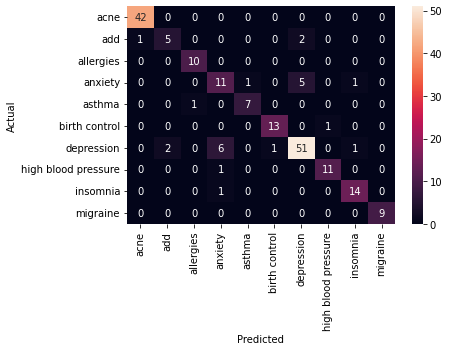

In [37]:
#plot confusion matrix in heatmap
cf_matrix = cf_matrix.pivot("Actual", "Predicted", "Num_Obs")

sns.heatmap(data=cf_matrix, annot=True)

The model can differentiate between the classes well for most of the classes. However it has more difficulty differentiating between anxiety and depression.

<AxesSubplot:xlabel='epoch_num', ylabel='value'>

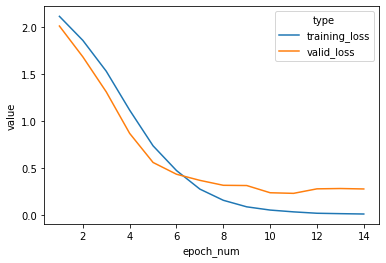

In [38]:
#obtain training and validation loss curve
#create dataframes for seaborn visualisation
trainloss_df = pd.DataFrame(train_loss_list, columns=['value'])
trainloss_df['type']='training_loss'
trainloss_df['epoch_num']=range(len(train_loss_list))
trainloss_df['epoch_num']=trainloss_df['epoch_num']+1
valloss_df = pd.DataFrame(val_loss_list, columns=['value'])
valloss_df['type']='valid_loss'
valloss_df['epoch_num']=range(len(val_loss_list))
valloss_df['epoch_num']=valloss_df['epoch_num']+1
combined_df = pd.concat([trainloss_df, valloss_df])
combined_df.reset_index(drop=True, inplace=True)
#plot train and val loss over epochs
sns.lineplot(data=combined_df,x='epoch_num', y='value', hue='type')